In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = False

function_folder = "uniform_sin(x)_241121"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

In [3]:
tensors['train'][1].shape

torch.Size([700])

# Evaluate KAN

In [ ]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 3, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [100]

    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


c:\Users\madel\5.1 Project Course in DS\KAN_Git\KAN-Kolmogorov-Arnold-Networks\KAN\KAN.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _dataset['train_label'] = torch.tensor(y).float()


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.26e-01 | test_loss: 4.37e-01 | reg: 7.18e+00 | : 100%|█| 100/100 [00:51<00:00,  1.95

saving model version 0.1
Best Parameters: {'kan__width': [1, 3, 3, 1], 'kan__seed': 42, 'kan__lr': 0.001, 'kan__lamb': 0.01, 'kan__k': 5, 'kan__grid': 3, 'kan__epochs': 100, 'kan__deepmimo': False, 'kan__data': []}
Best Cross-Validation Score: -10.081964221596717


In [5]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'],deepmimo=deepmimo, steps=100)
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.26e-01 | test_loss: 4.34e-01 | reg: 7.06e+00 | : 100%|█| 100/100 [01:02<00:00,  1.61

saving model version 0.1


In [6]:
if deepmimo:
    kan_model = KANModel(width=[1024, 10,10, 1024], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

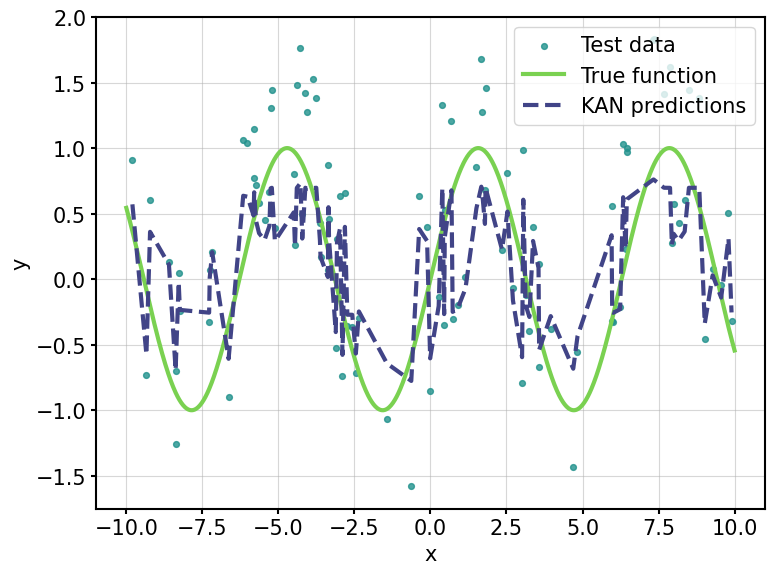

In [10]:
# plot pred and true
if deepmimo:
    kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [11]:
# plot noise and true
if deepmimo:
    kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [12]:
# diffrence in noise and true
torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

IndexError: too many indices for tensor of dimension 1

In [13]:
# diffrence pred and true
torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

IndexError: too many indices for tensor of dimension 1

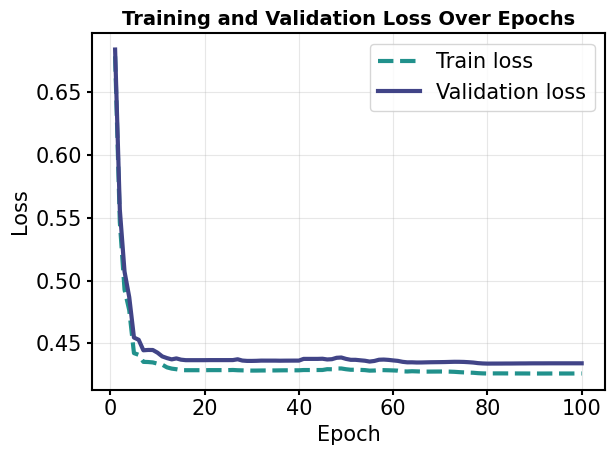

In [14]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [ ]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__steps': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [5],[5,3], [3,3,3]],
        'mlp__output_size': [1],
        'mlp__steps': [100],
        'mlp__deepmimo': [False]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=1,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

c:\Users\madel\5.1 Project Course in DS\KAN_Git\KAN-Kolmogorov-Arnold-Networks\MLP\MLPWrapper.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 42%|████▏     | 4222/9999 [00:26<00:35, 161.40it/s]


KeyboardInterrupt: 

In [ ]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 999/999 [00:01<00:00, 818.66it/s]


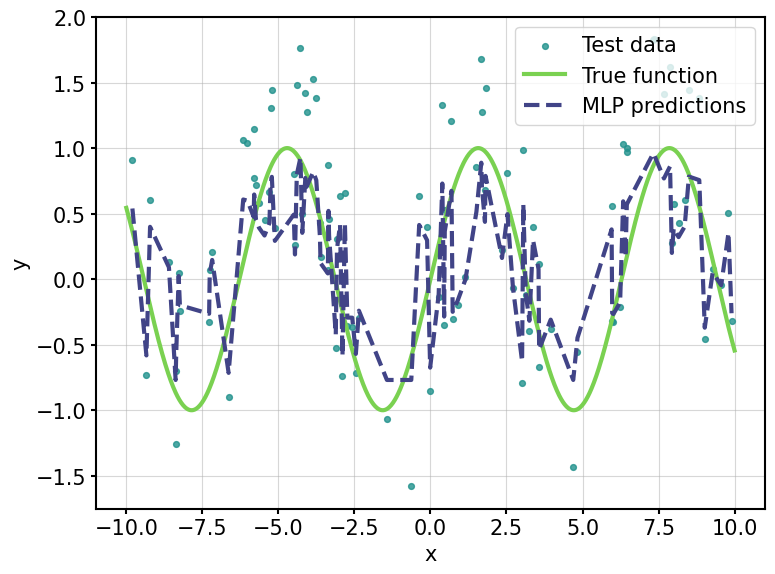

In [ ]:
# plot predictions
if deepmimo:
    mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

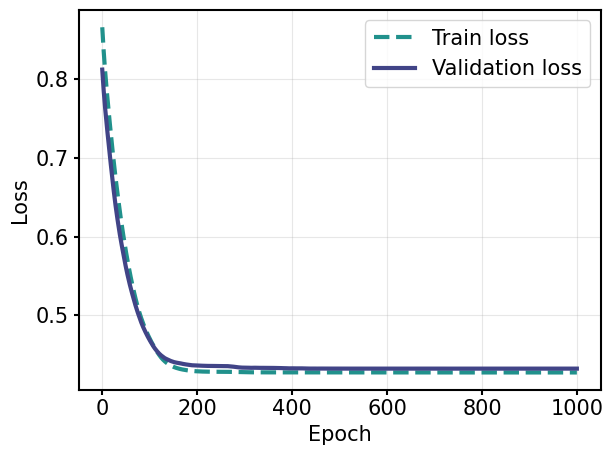

In [ ]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)